In [1]:
%matplotlib notebook
import numpy as np
import re
import pandas as pd
import orbipy as op
import matplotlib.pyplot as plt
import pickle

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='km', velocity_units='m/s')
scaler = plotter.scaler

In [3]:
with open('/home/alex/Desktop/pxdata_alternative.txt','r') as fp:
    data = fp.read()

In [4]:
class Polynomial:
    def __init__(self, data):
        self.pol = self.get_polynomial_data(data)
        
    def get_polynomial_data(self, data):
        pol = []
        for row in data.split('\n'):
            powers, coef = re.sub('[{},]','',row.replace('},', ';')).split(';')
            powers = list(map(lambda x: int(x), powers.split(' ')))
            coef = float(coef)
            pol.append([powers, coef])
        return pol
    
    def monomial_eval(self, monomial, states):
        powers = monomial[0]
        coef = monomial[1]
        return coef * np.power(states, powers).prod(axis=1)
    
    def eval(self, states):
        return np.array([self.monomial_eval(monomial, states) for monomial in self.pol]).sum(axis=0)

In [5]:
class SymplecticTransform:
    def __init__(self, model):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.symp_matrix = self.calc_symp_matrix()
        
    def c(self, n):
        return (self.mu + ((-1)**n)*(((1-self.mu)*self.gamma**(n+1))/((1-self.gamma)**(n+1))))/self.gamma**3
    
    def calc_symp_matrix(self):
        c2 = self.c(2)
        w1 = np.sqrt(-0.5*(c2-2-np.sqrt(9*c2**2-8*c2)))
        l1 = np.sqrt(0.5*(c2-2+np.sqrt(9*c2**2-8*c2)))
        w2 = np.sqrt(c2)
        s1 = np.sqrt(2*l1*((4+3*c2)*l1**2+4+5*c2-6*c2**2))
        s2 = np.sqrt(w1*((4+3*c2)*w1**2-4-5*c2+6*c2**2))
        R = np.array([[2*l1/s1,0,0,-2*l1/s1, 2*w1/s2,0],
                      [(l1**2-2*c2-1)/s1,(-1.*w1**2-2*c2-1)/s2,0,(l1**2-2*c2-1)/s1,0,0],
                      [0,0,1./np.sqrt(w2),0,0,0],
                      [(l1**2+2*c2+1)/s1,(-1.*w1**2+2*c2+1)/s2,0,(l1**2+2*c2+1)/s1,0,0],
                      [(l1**3+(1-2*c2)*l1)/s1,0,0,(-1.*l1**3-(1-2*c2)*l1)/s1,(-1.*w1**3+(1-2*c2)*w1)/s2,0],
                      [0,0,0,0,0,np.sqrt(w2)]])
        return R
    
    def apply(self, states):
        return states @ self.symp_matrix.T

In [6]:
class CanonicTransform:
    def __init__(self, data, model):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.poly = Polynomial(data)
        self.symplectic_transform = SymplecticTransform(model)
        
    def apply_shift_scale(self, states):
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
    
    def apply(self, states):
        after_shift = self.apply_shift_scale(states)
        after_symp = self.symplectic_transform.apply(after_shift)
        result = self.poly.eval(after_symp)
        return result

In [25]:
def manifolds(s0, dv, events, num=200):
    traj_upper = []
    traj_lower = []
#     shift = 0
    v_upper = np.linspace(s0[4], s0[4] + dv, num)[1:]
    v_lower = np.linspace(s0[4] - dv, s0[4], num)[:-1]
    det = op.event_detector(model, events)
    for v in v_upper:
        s1 = s0.copy()
        s1[4] = v
        orb, _ = det.prop(s1, 0.0, 1000, last_state='last')
        traj_upper.append(orb)
    for v in v_lower:
        s1 = s0.copy()
        s1[4] = v
        orb, _ = det.prop(s1, 0.0, 1000, last_state='last')
        traj_lower.append(orb)
    
    return traj_lower, traj_upper

In [12]:
with open('../../large_orbs_examples.bin', 'rb') as fp:
    orbs = pickle.load(fp)

In [7]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.plot(model.L1,0,'rx')
#     ax.plot(s0[0],s0[2],'xr')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [8]:
with open('../amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

<IPython.core.display.Javascript object>


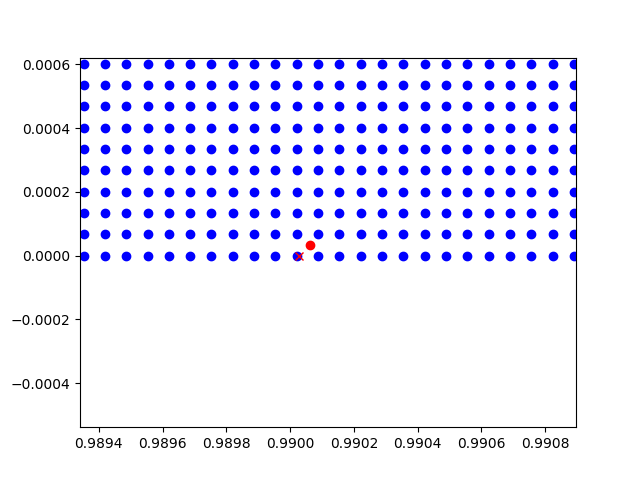

In [283]:
buffer = []
interactive_map(applicability, buffer)

In [284]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [285]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventXleft = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

In [286]:
corr = op.border_correction(model, op.y_direction(), left, right)

In [287]:
sk = op.simple_station_keeping(precise_model,corr, corr)

In [343]:
with open('../large_orbs2.bin', 'rb') as fp:
    lo2 = pickle.load(fp)

In [344]:
# orb = sk.prop(0.0, s0, 30)
orb = lo2[-2].copy()

## Исходня исследуемая орбита

<IPython.core.display.Javascript object>


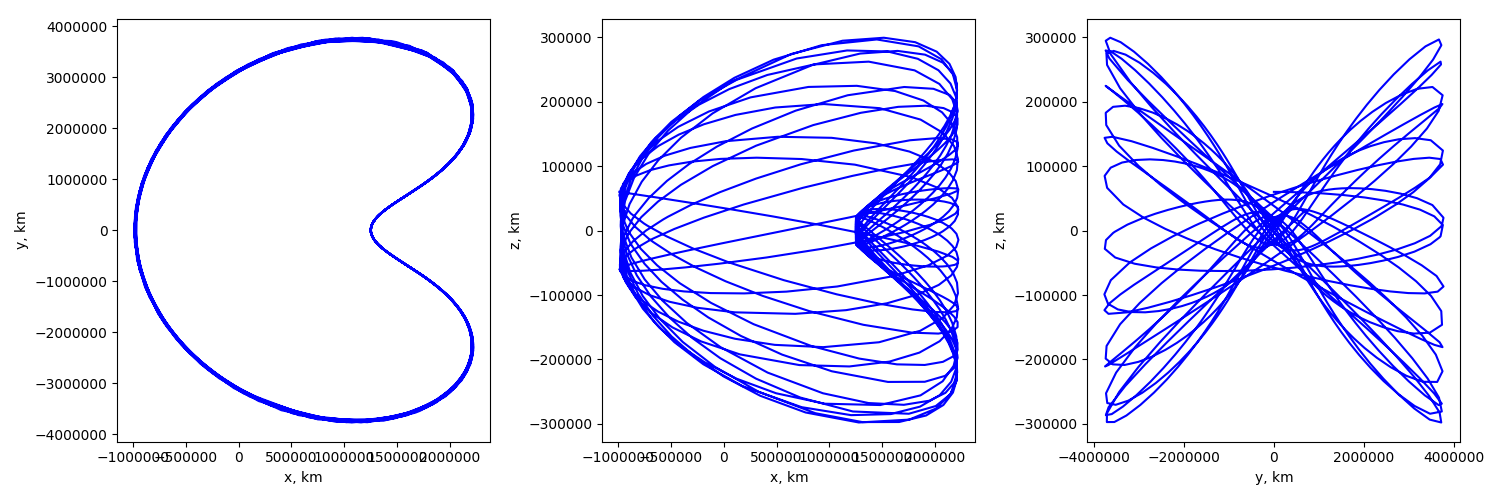

In [345]:
ax = plotter.plot_proj(orb, centers={'x': model.L1, 'y': 0.0, 'z': 0.0})
#plotter.plot_proj(ax=ax, plottables = [plotter.m], marker = 'o')

In [346]:
ct = CanonicTransform(data, model)

In [347]:
orb_states = orb.drop('t', axis=1).to_numpy()

In [348]:
p1_orb = ct.apply(orb_states)

<IPython.core.display.Javascript object>


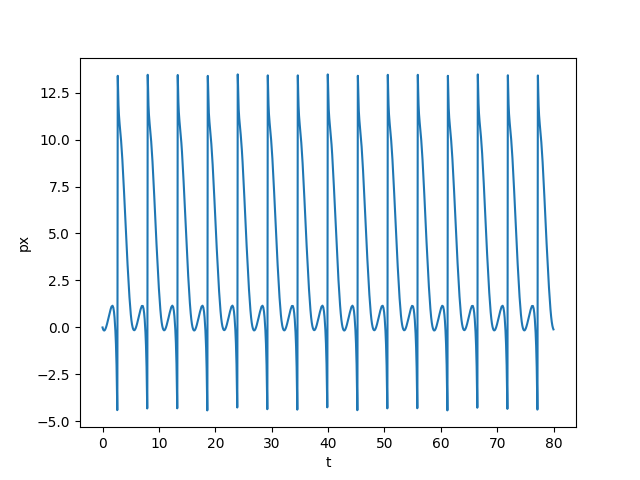

Text(0, 0.5, 'px')

In [349]:
plt.plot(orb['t'], p1_orb)
plt.xlabel('t')
plt.ylabel('px')

In [23]:
from scipy.optimize import fminbound

In [24]:
class EventPX(op.base_event):
    def __init__(self, data, model, value, terminal):
        self.ct = CanonicTransform(data, model)
        super().__init__(value=value, terminal=terminal)
    
    def __call__(self, t, s):
        px = self.ct.apply(np.array([s]))[0]
#         print(p1)
        return  px - self.value

In [25]:
from scipy.optimize import bisect

### Данный класс реализует алгоритм поиска  корректирующего импульса для построения орбиты вокруг точки либрации. Алгоритм основан на использовании неустойчивой компоненты движения px, полученной в результате канонического преобразования над гамильтонианом. Для работы требуется знать максимальное и минимальное (px_max, px_min) значения px для искомой орбиты.

In [358]:
class CTCorr:
    def __init__(self, events, data, direction):
        self.model = op.crtbp3_model()
        self.events = events
        self.det = op.event_detector(self.model, self.events)
        self.ct = CanonicTransform(data, self.model)
        self.direction = direction
        
    def dv_target(self, v, s0, p):
        s1 = s0.copy()
        s1[3:] += self.direction*v
        res1 = np.abs(self.ct.apply(np.array([s1]))[0] - p)
        return res1
    
    def parabola_target(self, v, s0):
        s1 = s0.copy()
        s1[3:] += self.direction*v
        res1 = self.ct.apply(np.array([s1]))[0]
        return res1
    
    def find_parabola_min(self, s0):
        return fminbound(self.parabola_target, -0.1, 0.1, [s0], xtol=1e-12, maxfun=1000)
    
    def find_dv(self, s0, p):
        split = self.find_parabola_min(s0)
        res1 = fminbound(self.dv_target, -0.5, split,(s0, p),xtol=1e-12, maxfun=1000)
        res2 = fminbound(self.dv_target, split, 0.5,(s0, p),xtol=1e-12, maxfun=1000)
        
        return [res1, res2]
    
    def find_dv_borders(self, s0, p1_max):
        v1, v2 = self.find_dv(s0, p1_max)
        vs = [v1,v2]
        return [min(vs),max(vs)]
    
    def target(self, v, s):
#         import pdb; pdb.set_trace()
#         self.vss.append(v)
        s1 = s.copy()
        s1[3:] += v*self.direction
        df, ev = self.det.prop(s1, 0.0, 1000)
        ev_happened = ev.iloc[0]['e']
        if ev_happened == 1:
#             print(1)
            return 1
        else:
#             print(-1)
            return -1
        
    def calc_dv(self, s):
#         self.vss = []
        p_max = max([self.events[0].value,self.events[1].value])
        v1, v2 = self.find_dv_borders(s, p_max)
#         print(v1,v2)
        shift = 0
        result = bisect(self.target, v1+shift, v2-shift, s)
        return np.hstack([np.zeros(3), self.direction*result])

### Используем сначала уже скорректированный вектор состояния, попробуем найти коррекцию, коррекция должна получиться нулевой.

In [436]:
right_px = EventPX(data, model, p1_orb.max()+0.001, True)
left_px = EventPX(data, model, p1_orb.min()-0.001, True)
events = [left_px, right_px]
s_test = orb.iloc[0].values[1:]
fcorr = CTCorr(events, data, op.y_direction.direction)
split_val = fcorr.find_parabola_min(s_test)
v_vals = fcorr.find_dv_borders(s_test, right_px.value)

In [437]:
dv=2*1e-1
vs = np.linspace(-dv, dv, 200)
pxs = [fcorr.parabola_target(v, s_test) for v in vs]

<IPython.core.display.Javascript object>


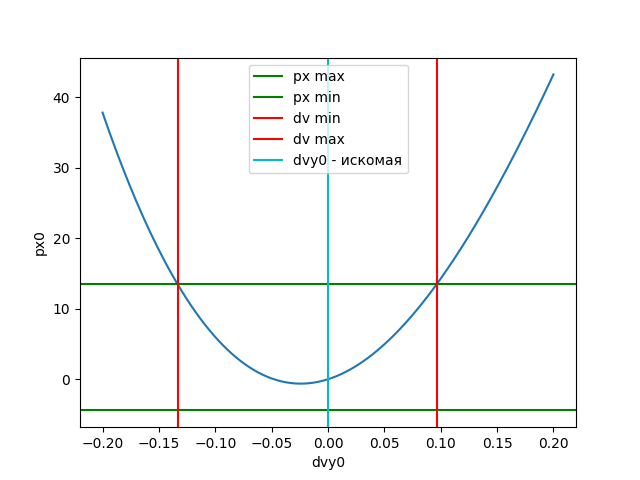

In [438]:
plt.plot(vs, pxs)
plt.axhline(right_px.value, color='g', label='px max')
plt.axhline(left_px.value, color='g', label='px min')
plt.axvline(v_vals[0], color='r',label='dv min')
plt.axvline(v_vals[1], color='r',label='dv max')
plt.axvline(0, color='c', label = 'dvy0 - искомая')


plt.ylabel('px0')
plt.xlabel('dvy0')
plt.legend()

In [439]:
search_dvs = np.linspace(v_vals[0], v_vals[1], 200)
evs = [fcorr.target(v, s_test) for v in search_dvs]

### Разрыв не соответствует искомому dv

<IPython.core.display.Javascript object>


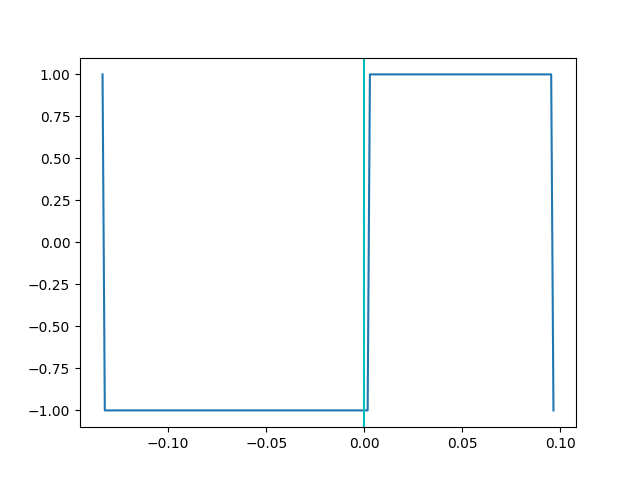

In [440]:
plt.plot(search_dvs, evs)
plt.axvline(0, color='c', label = 'dvy0 - искомая')
# plt.axvline(split_val)

In [415]:
dv_found = fcorr.calc_dv(s_test)

In [416]:
dv_found

array([ 0.        ,  0.        ,  0.        , -0.        , -0.13342071,
       -0.        ])

<IPython.core.display.Javascript object>


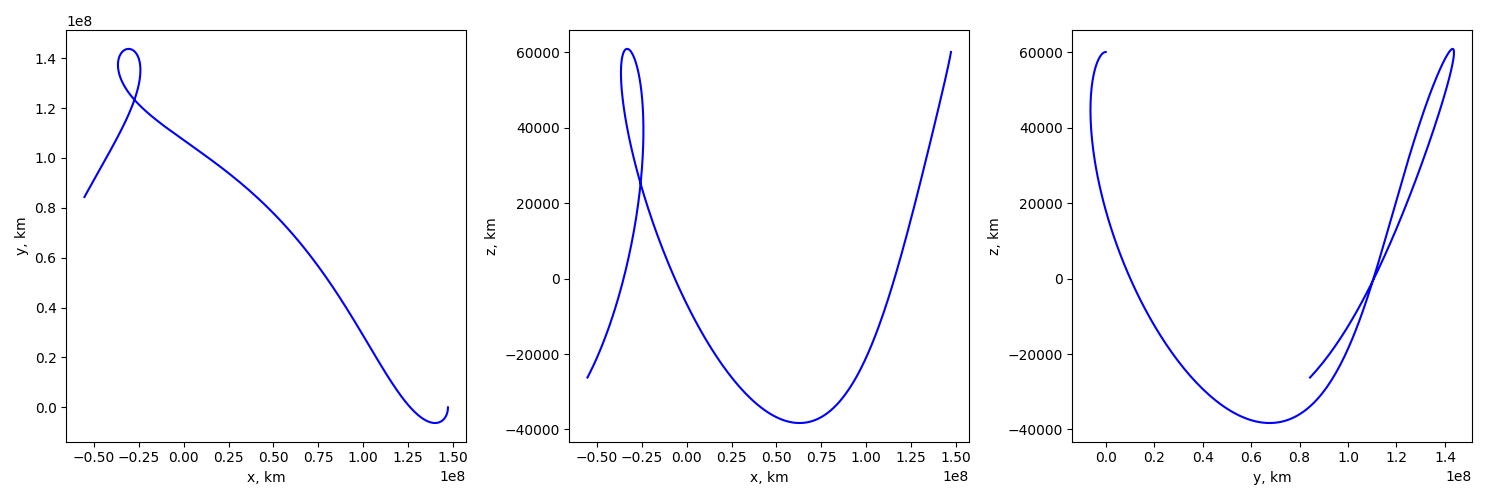

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f34120427b8>,
      dtype=object)

In [417]:
plotter.plot_proj(precise_model.prop(s_test+dv_found, 0.0, 2*np.pi))

### Используем возмущенный по скорости вектор состояния

In [423]:
right_px = EventPX(data, model, p1_orb.max()+1e-3, True)
left_px = EventPX(data, model, p1_orb.min()-1e-3, True)
events = [left_px, right_px]
s_test = orb.iloc[0].values[1:]
s_test2 = s_test.copy()
s_test2[3:] += np.array([0,1e-3,0])
fcorr = CTCorr(events, data, op.y_direction.direction)
split_val = fcorr.find_parabola_min(s_test2)
v_vals = fcorr.find_dv_borders(s_test2, right_px.value)

In [424]:
dv=2*1e-1
vs = np.linspace(-dv, dv, 200)
pxs = [fcorr.parabola_target(v, s_test2) for v in vs]

<IPython.core.display.Javascript object>


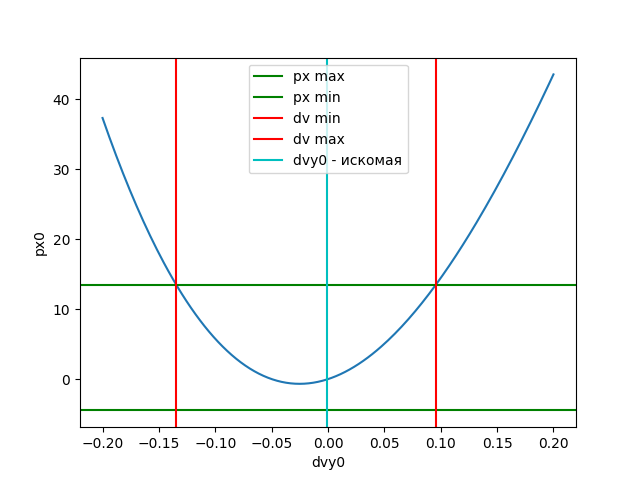

In [425]:
plt.plot(vs, pxs)
plt.axhline(right_px.value, color='g', label='px max')
plt.axhline(left_px.value, color='g', label='px min')
plt.axvline(v_vals[0], color='r',label='dv min')
plt.axvline(v_vals[1], color='r',label='dv max')
plt.axvline(s_test[4]-s_test2[4], color='c', label = 'dvy0 - искомая')


plt.ylabel('px0')
plt.xlabel('dvy0')
plt.legend()

In [426]:
search_dvs = np.linspace(v_vals[0], v_vals[1], 200)
evs = [fcorr.target(v, s_test2) for v in search_dvs]

### Разрыв не соответствует искомому dv

<IPython.core.display.Javascript object>


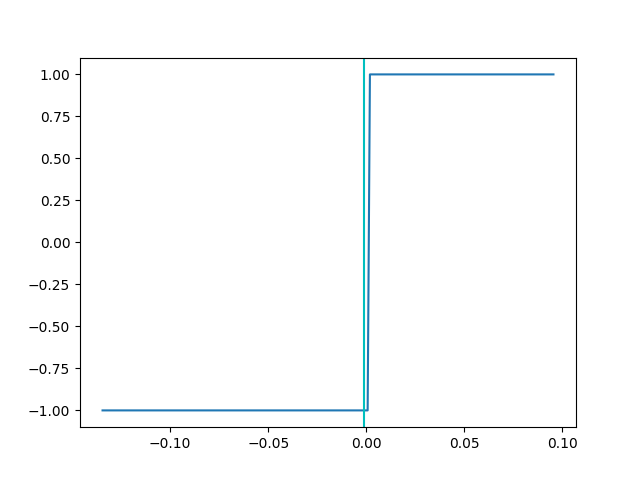

In [427]:
plt.plot(search_dvs, evs)
plt.axvline(s_test[4]-s_test2[4], color='c', label = 'dvy0 - искомая')

In [428]:
dv_found = fcorr.calc_dv(s_test2)

<IPython.core.display.Javascript object>


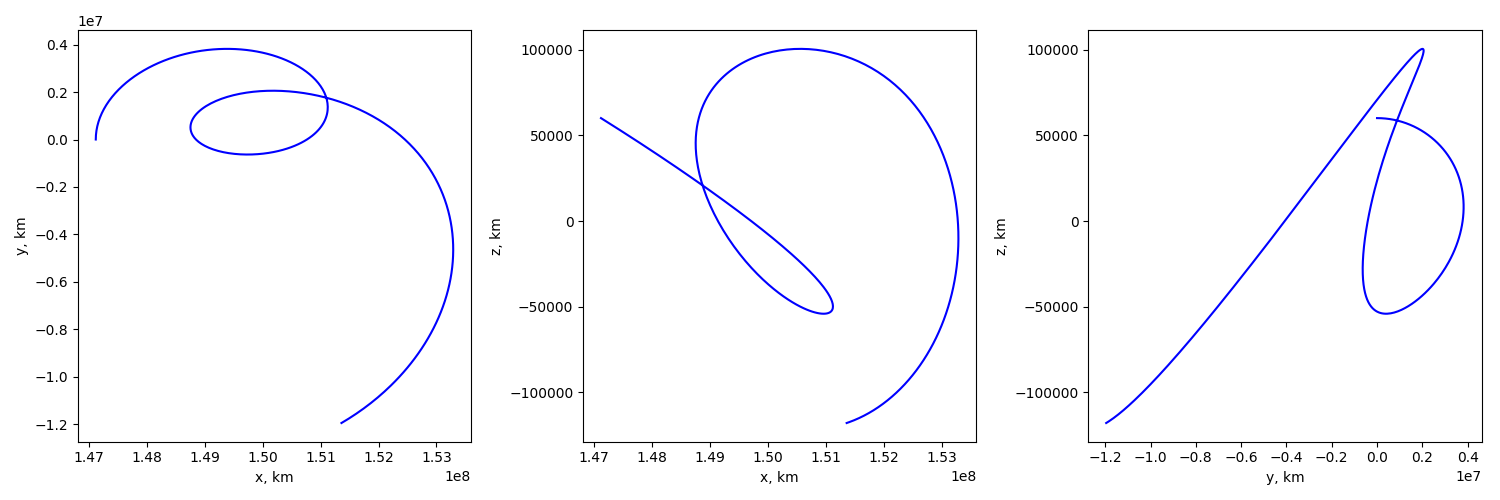

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3411bb02b0>,
      dtype=object)

In [435]:
plotter.plot_proj(precise_model.prop(s_test2+dv_found,0.0,2*np.pi))